In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The Data

$$
f(x_1, x_2) = 5 \cdot x_1 \cdot x_2 + \sin(6 \cdot (x_1 + x_2)) + \epsilon
$$


In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x1 = torch.linspace(0, 1, 100)
train_x2 = torch.linspace(0, 1, 100)
train_x = torch.hstack((train_x1.unsqueeze(-1), train_x2.unsqueeze(-1)) )
# True function is 5*x1*x2 + sin(6*(x1+x2))
train_y = 5 * train_x1 * train_x2 + torch.sin(6*(train_x1+train_x2)) + torch.randn(train_x1.size()) * 0.2

# **1. GP regression**

### The Model

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Train model

In [4]:
training_iter = 150


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/150 - Loss: 1.185   lengthscale: 0.693   noise: 0.693
Iter 2/150 - Loss: 1.141   lengthscale: 0.644   noise: 0.644
Iter 3/150 - Loss: 1.096   lengthscale: 0.598   noise: 0.598
Iter 4/150 - Loss: 1.053   lengthscale: 0.554   noise: 0.554
Iter 5/150 - Loss: 1.011   lengthscale: 0.513   noise: 0.513
Iter 6/150 - Loss: 0.969   lengthscale: 0.474   noise: 0.474
Iter 7/150 - Loss: 0.924   lengthscale: 0.437   noise: 0.437
Iter 8/150 - Loss: 0.873   lengthscale: 0.402   noise: 0.402
Iter 9/150 - Loss: 0.811   lengthscale: 0.370   noise: 0.370
Iter 10/150 - Loss: 0.737   lengthscale: 0.339   noise: 0.339
Iter 11/150 - Loss: 0.662   lengthscale: 0.310   noise: 0.311
Iter 12/150 - Loss: 0.595   lengthscale: 0.283   noise: 0.284
Iter 13/150 - Loss: 0.541   lengthscale: 0.259   noise: 0.259
Iter 14/150 - Loss: 0.495   lengthscale: 0.238   noise: 0.235
Iter 15/150 - Loss: 0.454   lengthscale: 0.219   noise: 0.214
Iter 16/150 - Loss: 0.417   lengthscale: 0.204   noise: 0.194
Iter 17/150 - Los

### Test model

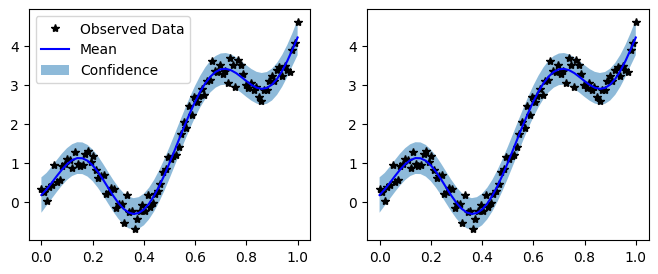

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x1 = torch.linspace(0, 1, 51)
    x2 = torch.linspace(0, 1, 51)
    test_x = torch.hstack((x1.unsqueeze(-1), x2.unsqueeze(-1)) )
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 2, figsize=(8, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # show the first dimension of the data
    ax[0].plot(train_x[:, 0].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[0].plot(test_x[:, 0].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[0].fill_between(test_x[:, 0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    #ax[0].set_ylim([-3, 3])
    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    # show the second dimension of the data
    ax[1].plot(train_x[:, 1].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[1].plot(test_x[:, 1].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[1].fill_between(test_x[:, 1].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    #ax[1].set_ylim([-3, 3])
    plt.show()

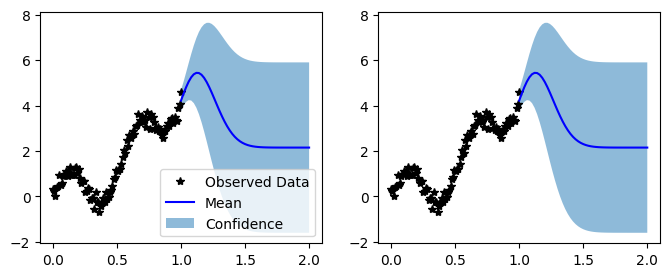

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x1 = torch.linspace(1, 2, 51)
    x2 = torch.linspace(1, 2, 51)
    test_x = torch.hstack((x1.unsqueeze(-1), x2.unsqueeze(-1)) )
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 2, figsize=(8, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # show the first dimension of the data
    ax[0].plot(train_x[:, 0].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[0].plot(test_x[:, 0].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[0].fill_between(test_x[:, 0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    # show the second dimension of the data
    ax[1].plot(train_x[:, 1].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[1].plot(test_x[:, 1].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[1].fill_between(test_x[:, 1].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    plt.show()

Observations:

 - Does well with the region with known data points.
 - Has large credible intervals as you move towards unknown regions.


## Get model info

In [7]:
# Viewing model hyperparameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -3.2513935565948486
Parameter name: mean_module.raw_constant                   value = 2.1514391899108887
Parameter name: covar_module.raw_outputscale               value = 3.4444918632507324
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.296952486038208


In [8]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.2514])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(2.1514)),
             ('covar_module.raw_outputscale', tensor(3.4445)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2970]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

## Save model

In [8]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'model_state.pth')

# **2. GP + ANN regression**

In [12]:
class GPWithNNFeatureExtractor(gpytorch.models.ExactGP):
    def __init__(self, input_shape, hidden_dim, train_x, train_y, likelihood):
        super(GPWithNNFeatureExtractor, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Linear(input_shape, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
training_iter = 15000

# initialize likelihood and model
ann_likelihood = gpytorch.likelihoods.GaussianLikelihood()
ann_model = GPWithNNFeatureExtractor(input_shape=2, hidden_dim=2, train_x=train_x, train_y=train_y, likelihood=ann_likelihood)


# Find optimal model hyperparameters
ann_model.train()
ann_likelihood.train()

# Use the adam optimizer
ann_optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(ann_likelihood, ann_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    ann_optimizer.zero_grad()
    # Output from model
    output = ann_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        ann_model.covar_module.base_kernel.lengthscale.item(),
        ann_model.likelihood.noise.item()
    ))
    ann_optimizer.step()

Iter 1/15000 - Loss: 2.192   lengthscale: 0.693   noise: 0.693
Iter 2/15000 - Loss: 2.178   lengthscale: 0.688   noise: 0.698
Iter 3/15000 - Loss: 2.139   lengthscale: 0.684   noise: 0.703
Iter 4/15000 - Loss: 2.051   lengthscale: 0.681   noise: 0.708
Iter 5/15000 - Loss: 1.913   lengthscale: 0.677   noise: 0.713
Iter 6/15000 - Loss: 1.785   lengthscale: 0.673   noise: 0.718
Iter 7/15000 - Loss: 1.689   lengthscale: 0.669   noise: 0.723
Iter 8/15000 - Loss: 1.606   lengthscale: 0.664   noise: 0.727
Iter 9/15000 - Loss: 1.536   lengthscale: 0.660   noise: 0.730
Iter 10/15000 - Loss: 1.478   lengthscale: 0.655   noise: 0.734
Iter 11/15000 - Loss: 1.430   lengthscale: 0.651   noise: 0.737
Iter 12/15000 - Loss: 1.393   lengthscale: 0.646   noise: 0.739
Iter 13/15000 - Loss: 1.365   lengthscale: 0.641   noise: 0.741
Iter 14/15000 - Loss: 1.344   lengthscale: 0.637   noise: 0.743
Iter 15/15000 - Loss: 1.328   lengthscale: 0.632   noise: 0.744
Iter 16/15000 - Loss: 1.315   lengthscale: 0.627 

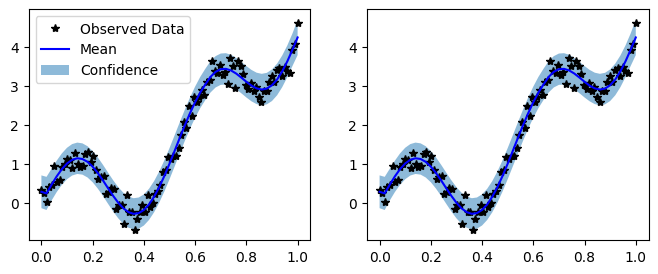

In [17]:
# Get into evaluation (predictive posterior) mode
ann_model.eval()
ann_likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x1 = torch.linspace(0, 1, 51)
    x2 = torch.linspace(0, 1, 51)
    test_x = torch.hstack((x1.unsqueeze(-1), x2.unsqueeze(-1)) )
    observed_pred = ann_likelihood(ann_model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 2, figsize=(8, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # show the first dimension of the data
    ax[0].plot(train_x[:, 0].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[0].plot(test_x[:, 0].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[0].fill_between(test_x[:, 0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    #ax[0].set_ylim([-3, 3])
    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    # show the second dimension of the data
    ax[1].plot(train_x[:, 1].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[1].plot(test_x[:, 1].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[1].fill_between(test_x[:, 1].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    #ax[1].set_ylim([-3, 3])
    plt.show()

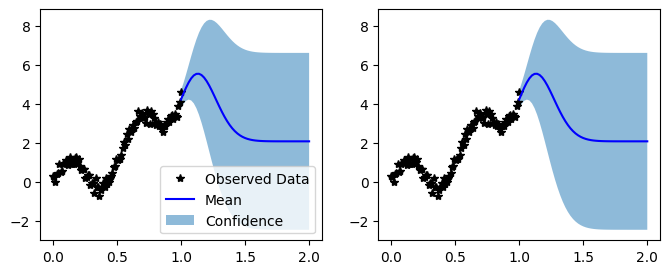

In [18]:
# Get into evaluation (predictive posterior) mode
ann_model.eval()
ann_likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x1 = torch.linspace(1, 2, 51)
    x2 = torch.linspace(1, 2, 51)
    test_x = torch.hstack((x1.unsqueeze(-1), x2.unsqueeze(-1)) )
    observed_pred = ann_likelihood(ann_model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 2, figsize=(8, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    # show the first dimension of the data
    ax[0].plot(train_x[:, 0].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[0].plot(test_x[:, 0].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[0].fill_between(test_x[:, 0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    ax[0].legend(['Observed Data', 'Mean', 'Confidence'])
    # show the second dimension of the data
    ax[1].plot(train_x[:, 1].numpy(), train_y.numpy(), 'k*') # Plot training data as black stars
    ax[1].plot(test_x[:, 1].numpy(), observed_pred.mean.numpy(), 'b') # Plot predictive means as blue line
    ax[1].fill_between(test_x[:, 1].numpy(), lower.numpy(), upper.numpy(), alpha=0.5) # Shade between the lower and upper confidence bounds
    plt.show()

In [19]:
ann_model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.2710])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(2.0876)),
             ('covar_module.raw_outputscale', tensor(5.0912)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.2790]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf)),
             ('feature_extractor.0.weight',
              tensor([[-1.0545,  0.1590],
                      [

References
- https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html